In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

In [2]:
train = pd.read_csv('Data/demand-forecasting-kernels-only/train.csv', parse_dates = ['date'])
test = pd.read_csv('Data/demand-forecasting-kernels-only/test.csv', parse_dates = ['date'])

train[:10]

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10
7,2013-01-08,1,1,9
8,2013-01-09,1,1,12
9,2013-01-10,1,1,9


In [3]:
train.isna().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


<AxesSubplot:>

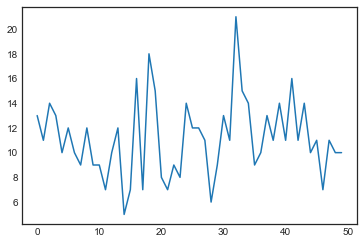

In [5]:
 train['sales'][:50].plot()

In [7]:
print(train['date'].min().date())
print(train['date'].max().date())

2013-01-01
2017-12-31


In [9]:
train_od = (train['date'].max().date() - train['date'].min().date()).days
test_od = (test['date'].max().date() - test['date'].min().date()).days

lag_size = (test['date'].max().date() - train['date'].max().date()).days

print('Train Odd: ' , train_od)
print('Test Odd: ' , test_od)

print('lag size: ', lag_size)

Train Odd:  1825
Test Odd:  89
lag size:  90


In [10]:
# 일일판매량 합
daily_sales = train.groupby(['date'], as_index = False)['sales'].sum()
# 가게별 일일판매량 합
store_daily_sales = train.groupby(['store', 'date'], as_index = False)['sales'].sum()
# 품목별 일일판매량 합
item_daily_sales = train.groupby(['item', 'date'], as_index = False)['sales'].sum()

#daily_sales

,date,sales
0,2013-01-01,13696
1,2013-01-02,13678
2,2013-01-03,14488
3,2013-01-04,15677
4,2013-01-05,16237
...,...,...
1821,2017-12-27,20378
1822,2017-12-28,21885
1823,2017-12-29,23535
1824,2017-12-30,24988


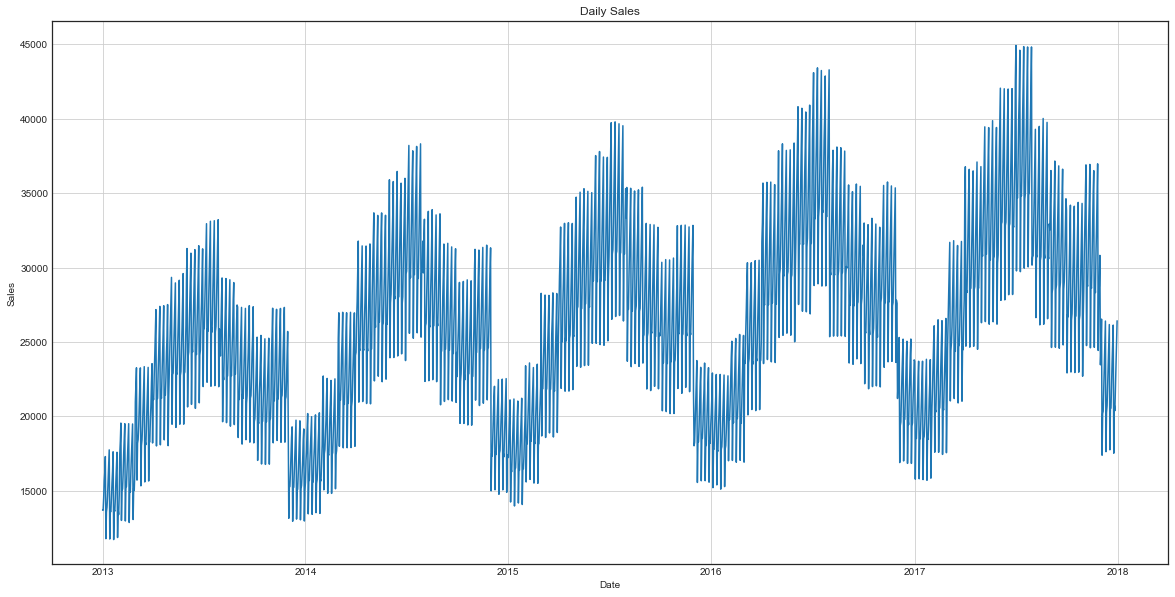

In [13]:
## 일별 총 판매량

plt.figure(figsize = (20, 10))
plt.plot(daily_sales['date'], daily_sales['sales'])
plt.title('Daily Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid()
plt.show()

Text(0, 0.5, 'Sales')

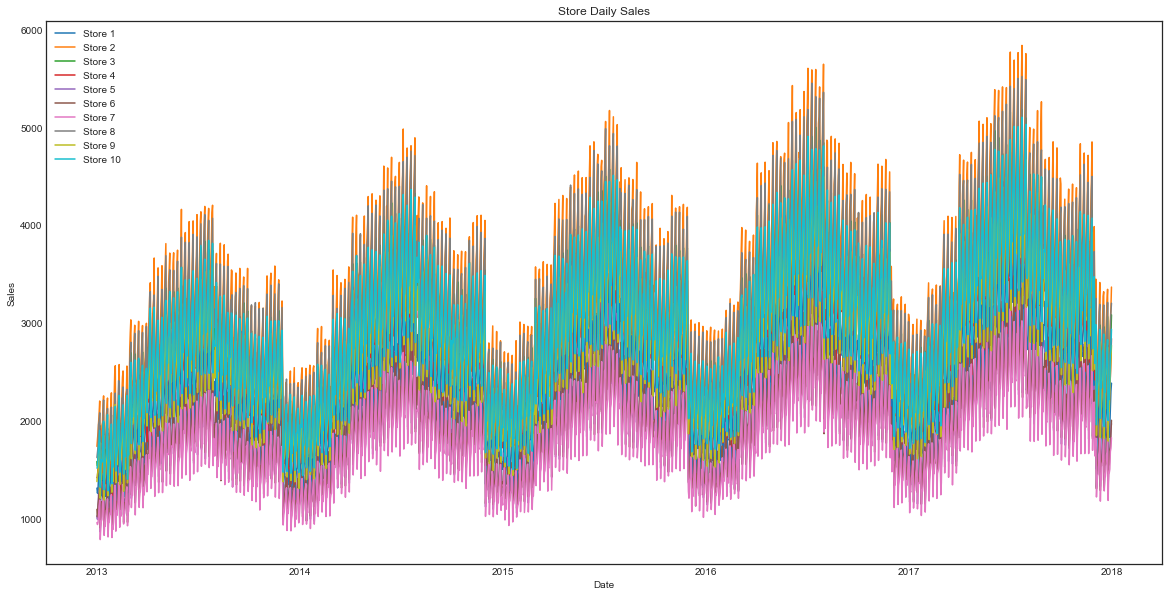

In [14]:
## 일별, 가게별 총 판매량

plt.figure(figsize = (20, 10))

for i in range(1, 11):
    temp = store_daily_sales[store_daily_sales.store == i]
    plt.plot(temp['date'], temp['sales'], label = 'Store %d' % i)
    
plt.legend()
plt.title('Store Daily Sales')
plt.xlabel('Date')
plt.ylabel('Sales')

Text(0, 0.5, 'Sales')

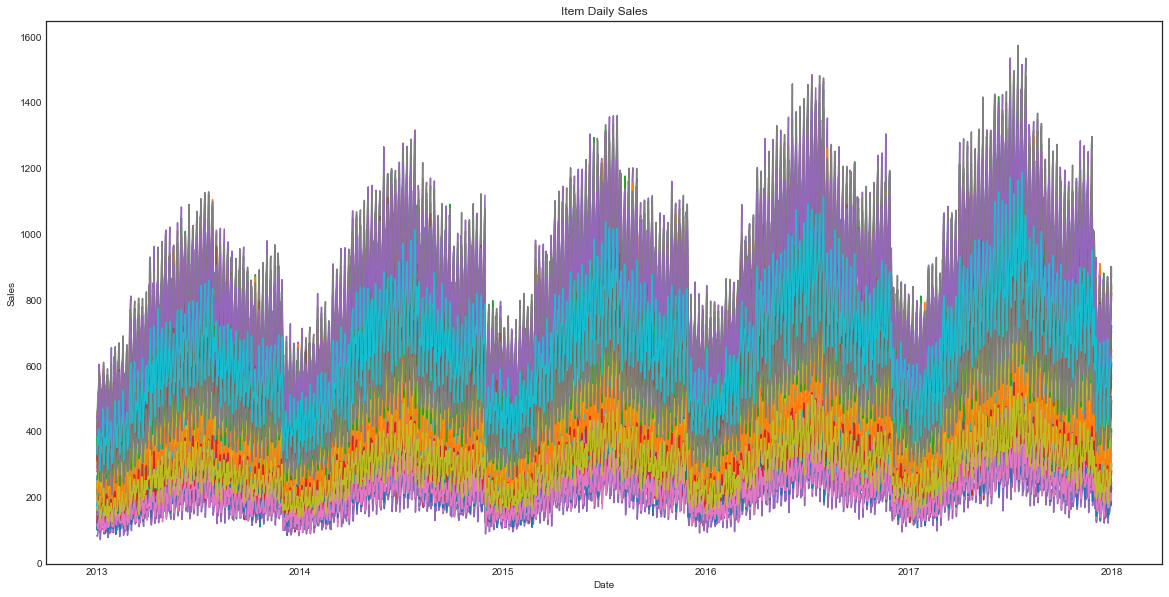

In [15]:
## 일별, 품목별 총 판매량

plt.figure(figsize = (20, 10))

for i in range(1, 51):
    temp = item_daily_sales[item_daily_sales.item== i]
    plt.plot(temp['date'], temp['sales'], label = 'Item %d' % i)
    
#plt.legend(loc = 'best')
plt.title('Item Daily Sales')
plt.xlabel('Date')
plt.ylabel('Sales')

## 전처리

In [16]:
train = train[(train['date'] >= '2017-01-01')]

In [17]:
# Transform data into a time series problem

def series_to_supervised(data, window = 1, lag = 1, dropna = True):
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t = 0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t = lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # put it all together
    agg = pd.concat(cols, axis = 1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropna:
        agg.dropna(inplace = True)
    return agg

train_gp = train.sort_values('date').groupby(['item', 'store', 'date'], as_index = False)
train_gp = train_gp.agg({'sales' : ['mean']})
train_gp.columns = ['item', 'store', 'date', 'sales']

window = 29
lag = lag_size
series = series_to_supervised(train_gp.drop('date', axis = 1), window = window, lag = lag)

last_item = 'item(t-%d)' % window
last_store = 'store(t-%d)' % window
series = series[(series['store(t)'] == series[last_store])]
series = series[(series['item(t)'] == series[last_item])]

columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['item', 'store']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['item', 'store']]
series.drop(columns_to_drop, axis = 1, inplace = True)
series.drop(['item(t)', 'store(t)'], axis = 1, inplace = True)

In [18]:
pd.set_option('display.max_columns', 15)
series

,sales(t-29),sales(t-28),sales(t-27),sales(t-26),sales(t-25),sales(t-24),sales(t-23),...,sales(t-5),sales(t-4),sales(t-3),sales(t-2),sales(t-1),sales(t),sales(t+90)
29,19.0,15.0,10.0,16.0,14.0,24.0,14.0,...,14.0,13.0,10.0,16.0,24.0,9.0,33.0
30,15.0,10.0,16.0,14.0,24.0,14.0,20.0,...,13.0,10.0,16.0,24.0,9.0,17.0,15.0
31,10.0,16.0,14.0,24.0,14.0,20.0,18.0,...,10.0,16.0,24.0,9.0,17.0,15.0,21.0
32,16.0,14.0,24.0,14.0,20.0,18.0,11.0,...,16.0,24.0,9.0,17.0,15.0,17.0,29.0
33,14.0,24.0,14.0,20.0,18.0,11.0,14.0,...,24.0,9.0,17.0,15.0,17.0,24.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182405,79.0,89.0,96.0,92.0,102.0,60.0,81.0,...,97.0,99.0,63.0,79.0,80.0,82.0,63.0
182406,89.0,96.0,92.0,102.0,60.0,81.0,79.0,...,99.0,63.0,79.0,80.0,82.0,90.0,59.0
182407,96.0,92.0,102.0,60.0,81.0,79.0,78.0,...,63.0,79.0,80.0,82.0,90.0,103.0,74.0
182408,92.0,102.0,60.0,81.0,79.0,78.0,97.0,...,79.0,80.0,82.0,90.0,103.0,99.0,62.0


In [19]:
series.columns

Index(['sales(t-29)', 'sales(t-28)', 'sales(t-27)', 'sales(t-26)',
       'sales(t-25)', 'sales(t-24)', 'sales(t-23)', 'sales(t-22)',
       'sales(t-21)', 'sales(t-20)', 'sales(t-19)', 'sales(t-18)',
       'sales(t-17)', 'sales(t-16)', 'sales(t-15)', 'sales(t-14)',
       'sales(t-13)', 'sales(t-12)', 'sales(t-11)', 'sales(t-10)',
       'sales(t-9)', 'sales(t-8)', 'sales(t-7)', 'sales(t-6)', 'sales(t-5)',
       'sales(t-4)', 'sales(t-3)', 'sales(t-2)', 'sales(t-1)', 'sales(t)',
       'sales(t+90)'],
      dtype='object')

In [20]:
# module 

from sklearn.model_selection import train_test_split

In [21]:
# label
labels_col = 'sales(t+%d)' % lag_size
labels = series[labels_col]
series = series.drop(labels_col, axis = 1)

x_train, x_val, y_train, y_val = train_test_split(series, labels.values, test_size = .4, random_state = 0)

print('Train set shape: ', x_train.shape)
print('Validation set shape: ', x_val.shape)

Train set shape:  (100746, 30)
Validation set shape:  (67164, 30)


## Setting to Parameters

In [22]:
# module 

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [23]:
epochs = 40
batch_size = 256
learning_rate = 1e-3
adam = optimizers.Adam(learning_rate)

In [24]:
model = Sequential()
model.add(Dense(100, activation = 'relu', input_shape = (None, x_train.shape[1])))
model.add(Dense(1))
model.compile(loss = 'mse', optimizer = adam)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, None, 100)         3100      
                                                                 
 dense_1 (Dense)             (None, None, 1)           101       
                                                                 
Total params: 3,201
Trainable params: 3,201
Non-trainable params: 0
_________________________________________________________________


In [25]:
#!pip install pydot

In [26]:
#!pip install graphviz

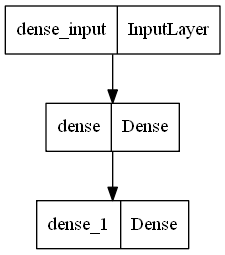

In [25]:
plot_model(model)

In [27]:
# Prediction

mlp_hist = model.fit(x_train.values, y_train, validation_data = (x_val.values, y_val), epochs = epochs, verbose = 2)

Epoch 1/40
3149/3149 - 7s - loss: 411.5572 - val_loss: 376.2176 - 7s/epoch - 2ms/step
Epoch 2/40
3149/3149 - 8s - loss: 367.2660 - val_loss: 371.8063 - 8s/epoch - 2ms/step
Epoch 3/40
3149/3149 - 8s - loss: 362.3326 - val_loss: 356.2082 - 8s/epoch - 2ms/step
Epoch 4/40
3149/3149 - 7s - loss: 358.1229 - val_loss: 391.2884 - 7s/epoch - 2ms/step
Epoch 5/40
3149/3149 - 6s - loss: 355.3994 - val_loss: 349.2090 - 6s/epoch - 2ms/step
Epoch 6/40
3149/3149 - 7s - loss: 353.4872 - val_loss: 357.4247 - 7s/epoch - 2ms/step
Epoch 7/40
3149/3149 - 7s - loss: 352.9398 - val_loss: 358.0913 - 7s/epoch - 2ms/step
Epoch 8/40
3149/3149 - 7s - loss: 350.7012 - val_loss: 377.4663 - 7s/epoch - 2ms/step
Epoch 9/40
3149/3149 - 7s - loss: 350.4565 - val_loss: 348.5174 - 7s/epoch - 2ms/step
Epoch 10/40
3149/3149 - 7s - loss: 349.2766 - val_loss: 351.5252 - 7s/epoch - 2ms/step
Epoch 11/40
3149/3149 - 7s - loss: 348.8810 - val_loss: 346.4531 - 7s/epoch - 2ms/step
Epoch 12/40
3149/3149 - 7s - loss: 349.2963 - val_lo

KeyboardInterrupt: 

In [107]:
pred_train = model.predict(x_train.values)
pred_val = model.predict(x_val.values)

y_train_ = pd.DataFrame({'y_true' : y_train, 'y_pred' : 
                        pred_train.reshape(pred_train.shape[0],)}).set_index(x_train.index).sort_index()
y_train_ = pd.merge(y_train_, train_gp, left_index = True, right_index = True, how = 'left')


y_val_ = pd.DataFrame({'y_true' : y_val, 'y_pred' : 
                     pred_val.reshape(pred_val.shape[0], )}).set_index(x_val.index).sort_index()
y_val_ = pd.merge(y_val_, train_gp, left_index = True, right_index = True, how = 'left')

In [108]:
from sklearn import metrics

def scoring(y_true, y_pred):
    r2 = round(metrics.r2_score(y_true, y_pred) * 100, 3)
    corr = round(np.corrcoef(y_true, y_pred)[0, 1], 3)
    mape = round(metrics.mean_absolute_percentage_error(y_true, y_pred) * 100, 3)
    rmse = round(metrics.mean_squared_error(y_true, y_pred, squared = False), 3)
    mae = round(metrics.mean_absolute_error(y_true, y_pred), 3)
    
    df = pd.DataFrame({'R2' : r2, 'Corr' : corr, 'RMSE' : rmse, 'MAPE' : mape, 'MAE' : mae}, index = [0])
    
    return df

In [109]:
scoring(y_train_.y_true, y_train_.y_pred)

C:\Users\Robin\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Robin\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


,R2,Corr,RMSE,MAPE,MAE
0,-331.721,NaN,65.709,97.603,57.599


In [110]:
scoring(y_val_.y_true, y_val_.y_pred)

C:\Users\Robin\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Robin\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


,R2,Corr,RMSE,MAPE,MAE
0,-332.254,NaN,65.541,97.6,57.462


In [ ]:
def abline(slope, intercept):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')
    
def MinMax(y_true, y_pred, m = 'min'):
    if(m == 'min'):
        return min(min(y_true), min(y_pred)) -2
    else:
        return max(max(y_true), max(y_pred)) + 2
    
def myGraph(temp, title):
    fig, axs = plt.subplots(1, 2, figsize = (20, 5), gridspec_kw = {'width_ratios' : [2.5, 1]})
    axs[0].plot(temp.date, temp.y_true, label = 'Original')
    

### CNN
    -  CNN 아키텍처로 시계열 분석을 하기위해 Input Data의 Shape을 모두 3차원으로 변형해준다.

In [111]:
x_train_series = x_train.values.reshape((x_train.shape[0], x_train.shape[1], 1))
x_val_series = x_val.values.reshape((x_val.shape[0], x_val.shape[1], 1))

In [112]:
print('Train set shape: ', x_train_series.shape)
print('Validation set shape: ', x_val_series.shape)

Train set shape:  (100746, 30, 1)
Validation set shape:  (67164, 30, 1)


In [113]:
# Module

from tensorflow.keras.layers import Conv1D, Flatten, MaxPooling1D

In [114]:
cnn_model = Sequential()
cnn_model.add(Conv1D(filters = 64, 
                     kernel_size = 2, 
                     activation = 'relu', 
                     input_shape = (x_train_series.shape[1], x_train_series.shape[2])))
cnn_model.add(MaxPooling1D(pool_size = 2))
cnn_model.add(Flatten())
cnn_model.add(Dense(50, activation = 'relu'))
cnn_model.add(Dense(1))
cnn_model.compile(loss = 'mse',
                 optimizer = adam)

cnn_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 29, 64)            192       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 14, 64)           0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 896)               0         
                                                                 
 dense_8 (Dense)             (None, 50)                44850     
                                                                 
 dense_9 (Dense)             (None, 1)                 51        
                                                                 
Total params: 45,093
Trainable params: 45,093
Non-trainable params: 0
__________________________________________________

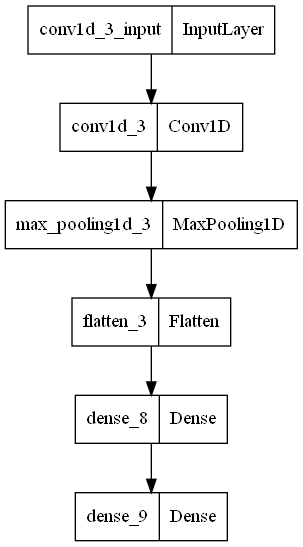

In [115]:
plot_model(cnn_model)

![cnn](2d_cnn.PNG)

In [116]:
cnn_hist = cnn_model.fit(x_train_series, y_train, validation_data = (x_val_series, y_val), epochs = epochs, verbose = 2)

Epoch 1/40
3149/3149 - 10s - loss: 409.7290 - val_loss: 398.3546 - 10s/epoch - 3ms/step
Epoch 2/40
3149/3149 - 9s - loss: 380.9493 - val_loss: 370.5463 - 9s/epoch - 3ms/step
Epoch 3/40
3149/3149 - 10s - loss: 370.2761 - val_loss: 364.2077 - 10s/epoch - 3ms/step
Epoch 4/40
3149/3149 - 10s - loss: 367.1134 - val_loss: 356.9257 - 10s/epoch - 3ms/step
Epoch 5/40
3149/3149 - 10s - loss: 363.4557 - val_loss: 356.0024 - 10s/epoch - 3ms/step
Epoch 6/40
3149/3149 - 10s - loss: 360.3717 - val_loss: 363.3048 - 10s/epoch - 3ms/step
Epoch 7/40
3149/3149 - 10s - loss: 358.9326 - val_loss: 355.2863 - 10s/epoch - 3ms/step
Epoch 8/40
3149/3149 - 10s - loss: 358.2103 - val_loss: 357.2771 - 10s/epoch - 3ms/step
Epoch 9/40
3149/3149 - 10s - loss: 357.0782 - val_loss: 370.5583 - 10s/epoch - 3ms/step
Epoch 10/40
3149/3149 - 10s - loss: 356.5753 - val_loss: 366.1145 - 10s/epoch - 3ms/step
Epoch 11/40
3149/3149 - 10s - loss: 355.6032 - val_loss: 355.0889 - 10s/epoch - 3ms/step
Epoch 12/40
3149/3149 - 10s - lo

In [117]:
cnn_pred_train = cnn_model.predict(x_train_series)
cnn_pred_val = cnn_model.predict(x_val_series)

y_train_ = pd.DataFrame({'y_true' : y_train, 'y_pred' : 
                        cnn_pred_train.reshape(cnn_pred_train.shape[0],)}).set_index(x_train.index).sort_index()
y_train_ = pd.merge(y_train_, train_gp, left_index = True, right_index = True, how = 'left')


y_val_ = pd.DataFrame({'y_true' : y_val, 'y_pred' : 
                     cnn_pred_val.reshape(cnn_pred_val.shape[0], )}).set_index(x_val.index).sort_index()
y_val_ = pd.merge(y_val_, train_gp, left_index = True, right_index = True, how = 'left')

In [118]:
scoring(y_train_.y_true, y_train_.y_pred)

,R2,Corr,RMSE,MAPE,MAE
0,63.914,0.808,18.997,33.501,14.627


In [119]:
scoring(y_val_.y_true, y_val_.y_pred)

,R2,Corr,RMSE,MAPE,MAE
0,63.39,0.805,19.074,33.542,14.675


### LSTM

In [68]:
!pip install --upgrade keras

In [70]:
from tensorflow.keras.layers import LSTM

In [64]:
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation = 'relu', input_shape = (x_train_series.shape[1], x_train_series.shape[2])))
lstm_model.add(Dense(1))
lstm_model.compile(loss = 'mse',
                  optimizer = adam)

![lstm_modeling](lstm_.png)

![lstm_modeling2](lstm_1.png)

In [66]:
lstm_hist = lstm_model.fit(x_train_series, y_train, validation_data = (x_val_series, y_val), epochs = 30, verbose = 2)

Epoch 1/30


KeyboardInterrupt: 

In [ ]:
lstm_pred_train = lstm_model.predict(x_train_series)
lstm_pred_val = lstm_model.predict(x_val_series)

y_train_ = pd.DataFrame({'y_true' : y_train, 'y_pred' : 
                        lstm_pred_train.reshape(lstm_pred_train.shape[0],)}).set_index(x_train.index).sort_index()
y_train_ = pd.merge(y_train_, train_gp, left_index = True, right_index = True, how = 'left')


y_val_ = pd.DataFrame({'y_true' : y_val, 'y_pred' : 
                     lstm_pred_val.reshape(lstm_pred_val.shape[0], )}).set_index(x_val.index).sort_index()
y_val_ = pd.merge(y_val_, train_gp, left_index = True, right_index = True, how = 'left')

## CNN + LSTM
    - 4차원으로 변형

![CNN-LSTM](cnn-lstm1.png)

*  출처 : https://leedakyeong.tistory.com/entry/Deep-Learning-for-Time-Series-Forecasting-kaggle

![CNN-LSTM](cnn-lstm2.png)

*  출처 : https://leedakyeong.tistory.com/entry/Deep-Learning-for-Time-Series-Forecasting-kaggle

![CNN-LSTM](cnn-lstm3.png)

*  출처 : https://leedakyeong.tistory.com/entry/Deep-Learning-for-Time-Series-Forecasting-kaggle

![CNN-LSTM](cnn-lstm4.png)

*  출처 : https://leedakyeong.tistory.com/entry/Deep-Learning-for-Time-Series-Forecasting-kaggle

In [120]:
subsequences = 2
timesteps = x_train_series.shape[1] // subsequences
x_train_series_sub = x_train_series.reshape((x_train_series.shape[0], subsequences, timesteps, 1))
x_val_series_sub = x_val_series.reshape((x_val_series.shape[0], subsequences, timesteps, 1))

print('Train set shape: ', x_train_series_sub.shape)
print('Validation set shape: ', x_val_series_sub.shape)

Train set shape:  (100746, 2, 15, 1)
Validation set shape:  (67164, 2, 15, 1)


In [121]:
from tensorflow.keras.layers import RepeatVector, TimeDistributed

In [122]:
# model architecture

cnn_lstm_model = Sequential()
cnn_lstm_model.add(TimeDistributed(Conv1D(filters = 64, kernel_size = 1,
                                         activation = 'relu'), input_shape = (None, x_train_series_sub.shape[2],
                                                                             x_train_series_sub.shape[3])))
cnn_lstm_model.add(TimeDistributed(MaxPooling1D(pool_size = 2)))
cnn_lstm_model.add(TimeDistributed(Flatten()))
cnn_lstm_model.add(LSTM(50, activation = 'relu'))
cnn_lstm_model.add(Dense(1))
cnn_lstm_model.compile(loss = 'mse', optimizer = adam)

In [123]:
cnn_lstm_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDis  (None, None, 15, 64)     128       
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, None, 7, 64)      0         
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, None, 448)        0         
 tributed)                                                       
                                                                 
 lstm_2 (LSTM)               (None, 50)                99800     
                                                                 
 dense_10 (Dense)            (None, 1)                 51        
                                                      

In [124]:
cnn_lstm_hist = cnn_lstm_model.fit(x_train_series_sub, y_train, 
                                  validation_data = (x_val_series_sub, y_val), epochs = epochs, verbose = 2)

Epoch 1/40
3149/3149 - 31s - loss: 418.9229 - val_loss: 397.6221 - 31s/epoch - 10ms/step
Epoch 2/40
3149/3149 - 29s - loss: 398.5174 - val_loss: 388.2627 - 29s/epoch - 9ms/step
Epoch 3/40
3149/3149 - 30s - loss: 390.4110 - val_loss: 381.2955 - 30s/epoch - 10ms/step
Epoch 4/40
3149/3149 - 30s - loss: 385.5929 - val_loss: 377.0933 - 30s/epoch - 10ms/step
Epoch 5/40
3149/3149 - 31s - loss: 380.4482 - val_loss: 379.9762 - 31s/epoch - 10ms/step
Epoch 6/40
3149/3149 - 30s - loss: 374.1095 - val_loss: 369.2798 - 30s/epoch - 10ms/step
Epoch 7/40
3149/3149 - 29s - loss: 369.0920 - val_loss: 366.0530 - 29s/epoch - 9ms/step
Epoch 8/40
3149/3149 - 28s - loss: 366.4846 - val_loss: 369.2050 - 28s/epoch - 9ms/step
Epoch 9/40
3149/3149 - 30s - loss: 363.5424 - val_loss: 360.3486 - 30s/epoch - 9ms/step
Epoch 10/40
3149/3149 - 31s - loss: 362.0752 - val_loss: 358.8826 - 31s/epoch - 10ms/step
Epoch 11/40
3149/3149 - 31s - loss: 361.6019 - val_loss: 357.7892 - 31s/epoch - 10ms/step
Epoch 12/40
3149/3149 -

In [126]:
cnn_lstm_pred_train = cnn_lstm_model.predict(x_train_series_sub)
cnn_lstm_pred_val = cnn_lstm_model.predict(x_val_series_sub)

y_train_ = pd.DataFrame({'y_true' : y_train, 'y_pred' : 
                        cnn_lstm_pred_train.reshape(cnn_lstm_pred_train.shape[0],)}).set_index(x_train.index).sort_index()
y_train_ = pd.merge(y_train_, train_gp, left_index = True, right_index = True, how = 'left')


y_val_ = pd.DataFrame({'y_true' : y_val, 'y_pred' : 
                     cnn_lstm_pred_val.reshape(cnn_lstm_pred_val.shape[0], )}).set_index(x_val.index).sort_index()
y_val_ = pd.merge(y_val_, train_gp, left_index = True, right_index = True, how = 'left')

In [127]:
scoring(y_train_.y_true, y_train_.y_pred)

,R2,Corr,RMSE,MAPE,MAE
0,65.2,0.809,18.656,30.805,14.164


In [128]:
scoring(y_val_.y_true, y_val_.y_pred)

,R2,Corr,RMSE,MAPE,MAE
0,64.76,0.806,18.714,30.868,14.22


Text(0.5, 1.0, 'CNN-LSTM')

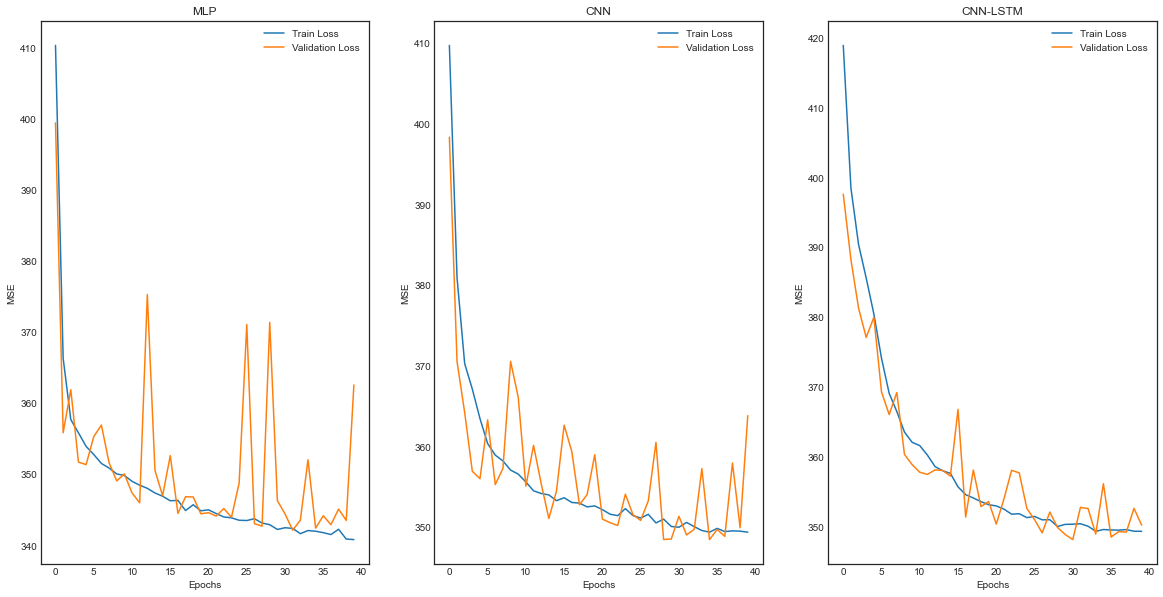

In [155]:
plt.figure(figsize = (20, 10))

plt.subplot(1, 3, 1)
plt.plot(mlp_hist.history['loss'], label = 'Train Loss')
plt.plot(mlp_hist.history['val_loss'], label = 'Validation Loss')
plt.legend(loc = 'best')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('MLP')

plt.subplot(1, 3, 2)
plt.plot(cnn_hist.history['loss'], label = 'Train Loss')
plt.plot(cnn_hist.history['val_loss'], label = 'Validation Loss')
plt.legend(loc = 'best')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('CNN')

plt.subplot(1, 3, 3)
plt.plot(cnn_lstm_hist.history['loss'], label = 'Train Loss')
plt.plot(cnn_lstm_hist.history['val_loss'], label = 'Validation Loss')
plt.legend(loc = 'best')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('CNN-LSTM')

- In the dataset, Outperformed to the most-comfortable performance at CNN-LSTM model

## 구현 모델
    -  MLP, CNN, LSTM(fitting속도 이슈로 x), CNN-LSTM

## Paper Reading
    - 'Dimensional Sentiment Analysis Using a Regional CNN-LSTM Model' : CNN-LSTM 데이터 Input shape(Dimension)문제를 다룸
    - Convolutional layer, Max-pooling layer, Sequential layer의 역사와 용도
    - Regional CNN, Regional CNN-LSTM의 개념을 알아볼 수 있었음
## 결과
    - 각 모델에 대해 좀더 심층적인 원론을 탐구해 볼 수 있었음
    - 난생 처음해본 논문정독
    - 그래프비쥬얼 코딩능력 향상